# Dataset & Dataloader

In [1]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torch.nn.utils.rnn import pad_sequence

class TextDataset(Dataset):
    def __init__(self, file_path):
        data = pd.read_csv(file_path)
        sentences = data['Sentence'].tolist()
        transformed_sentences = data['Transformed sentence'].tolist()

        char_to_index = lambda char: ord(char) - ord('a')
        self.indexed_sentences = [[char_to_index(char) for char in sentence] for sentence in sentences]
        self.indexed_transformed_sentences = [[26] + [char_to_index(char) for char in transformed_sentence] for transformed_sentence in transformed_sentences]

    def __len__(self):
        return len(self.indexed_sentences)

    def __getitem__(self, idx):
        sentence = torch.tensor(self.indexed_sentences[idx], dtype=torch.long)
        transformed_sentence = torch.tensor(self.indexed_transformed_sentences[idx], dtype=torch.long)
        return sentence, transformed_sentence

def get_dataloader(file_path, batch_size):
    dataset = TextDataset(file_path=file_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

In [3]:
file_path = './data/train_data.csv'
for src, tgt in get_dataloader(file_path, batch_size=5):
    print(src.shape, tgt.shape)
    break

torch.Size([5, 8]) torch.Size([5, 9])


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Model Architecture

In [5]:
import math
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [6]:
import torch
import torch.nn as nn
from transformer.transformer import Transformer

class Freddy(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, ffn_hidden, vocab_size, max_seq_len):
        super(Freddy, self).__init__()

        self.src_embedding = nn.Embedding(vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_embeddings = nn.Embedding(max_seq_len, d_model)

        self.transformer = Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, ffn_hidden, dropout=None)
        self.linear = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt, use_mask=True):
        src_positions = torch.arange(src.size(1)).unsqueeze(0).expand(src.size(0), -1).to(src.device)
        tgt_positions = torch.arange(tgt.size(1)).unsqueeze(0).expand(tgt.size(0), -1).to(tgt.device)

        src = self.src_embedding(src) + self.positional_embeddings(src_positions)
        tgt = self.tgt_embedding(tgt) + self.positional_embeddings(tgt_positions)

        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)
        output = self.transformer(src, tgt, tgt_mask=tgt_mask)
        
        output = self.linear(output)

        return output
    
    def predict(self, src, n=8):
        self.eval()
        device = next(self.parameters()).device
        src = torch.tensor([ord(char) - ord('a') for char in src], dtype=torch.long).unsqueeze(0).to(device)
        tgt = torch.tensor([[26]], dtype=torch.long).to(device)

        output_str = ""
        with torch.no_grad():
            for _ in range(n):
                logits = self(src, tgt).squeeze(0)
                predicted_index = torch.argmax(logits, dim=1)
                next_character = 'a' if predicted_index[-1].item() == 26 else chr(predicted_index[-1].item() + ord('a'))
                output_str += next_character
                tgt = torch.cat((tgt, predicted_index[-1].unsqueeze(0).unsqueeze(0)), dim=1)

        return ''.join([chr(token + ord('a')) if token != 26 else 'a' for token in tgt[0].cpu().numpy()])[1:]

In [7]:
src_vocab_size = 26
tgt_vocab_size = src_vocab_size + 1  # add the <s> token
d_model = 64
ffn_hidden = 256
nhead = 4
num_encoder_layers = num_decoder_layers = 2

fredbear = Freddy(
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    ffn_hidden=ffn_hidden,
    vocab_size=tgt_vocab_size,
    max_seq_len=1024
).to(device)

for src, tgt in get_dataloader(file_path, batch_size=5):
    src, tgt = src.to(device), tgt.to(device)

    tgt_input = tgt[:, :-1]
    tgt_output = tgt[:, 1:]

    print(src.shape, tgt_input.shape)

    output = fredbear(src, tgt_input)
    print(output.shape)

    print(fredbear.predict("abcdabcd"))
    break

torch.Size([5, 8]) torch.Size([5, 8])


torch.Size([5, 8, 27])
kvakwwww


# Training

In [8]:
def train_step(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    # for src, tgt in tqdm(train_loader, desc='Train'):
    for src, tgt in train_loader:
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()

        output = model(src, tgt_input)

        loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

    total_loss /= len(train_loader)
    return total_loss

def eval_step(model, eval_loader, criterion):
    model.eval()
    total_loss = 0
    score = 0
    with torch.no_grad():
        # for src, tgt in tqdm(eval_loader, desc='Eval'):
        for src, tgt in eval_loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)

            loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
            total_loss += loss.item()

            predicted = torch.argmax(output, dim=2)
            score += ((predicted == tgt_output).sum(dim=1)).sum().item()

    total_loss /= len(eval_loader)
    score /= (len(eval_loader) * eval_loader.batch_size)
    return total_loss, score

In [9]:
# set seed
# torch.random.manual_seed(1)

# setup model
src_vocab_size = 26
tgt_vocab_size = src_vocab_size + 1  # add the <s> token
d_model = 64
ffn_hidden = 256
nhead = 4
num_encoder_layers = num_decoder_layers = 2

model = Freddy(
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    ffn_hidden=ffn_hidden,
    vocab_size=tgt_vocab_size,
    max_seq_len=128
).to(device)

learning_rate = 0.0001
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

c:\Users\venna\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


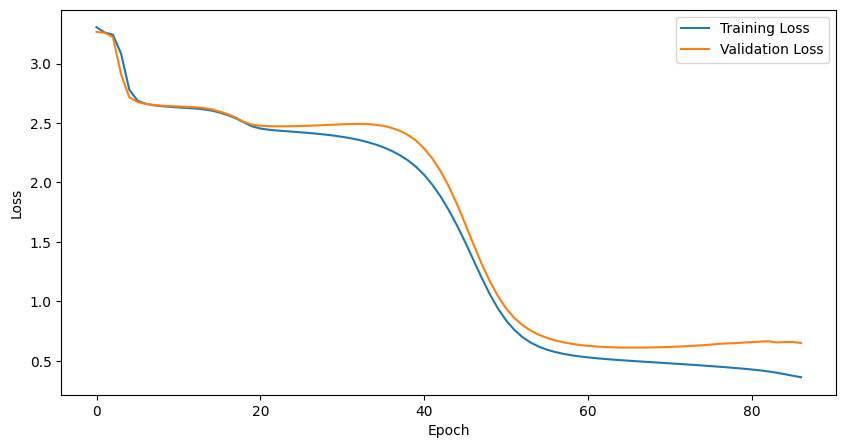

20, 0.6112197770012749, 5.25
Stopped Early, Best Eval Loss: 0.6112197770012749


In [10]:
# import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# sns.set_style('darkgrid')

def plot_losses(train_losses, eval_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(eval_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# train loop
train_losses = []
eval_losses = []

best_eval_loss = float('inf')
patience = 20
counter = 0

train_loader = get_dataloader('data/train_data.csv', batch_size=32)
eval_loader = get_dataloader('data/eval_data.csv', batch_size=32)

for epoch in range(epochs):
    clear_output(wait=True)

    train_loss = train_step(model, train_loader, criterion, optimizer)
    eval_loss, score = eval_step(model, eval_loader, criterion)

    train_losses.append(train_loss)
    eval_losses.append(eval_loss)
    plot_losses(train_losses, eval_losses)

    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        torch.save(model.state_dict(), 'model.pth')
        counter = 0

    print(f'{counter}, {best_eval_loss}, {score}')

    if counter >= patience:
        print(f"Stopped Early, Best Eval Loss: {best_eval_loss}")
        break

    counter += 1

# Load Model

In [27]:
src_vocab_size = 26
tgt_vocab_size = src_vocab_size + 1  # add the <s> token
d_model = 64
ffn_hidden = 256
nhead = 4
num_encoder_layers = num_decoder_layers = 2

model = Freddy(
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    ffn_hidden=ffn_hidden,
    vocab_size=tgt_vocab_size,
    max_seq_len=128
).to(device)
model.load_state_dict(torch.load('model.pth', map_location=device))

model.eval()

Freddy(
  (src_embedding): Embedding(27, 64)
  (tgt_embedding): Embedding(27, 64)
  (positional_embeddings): Embedding(128, 64)
  (transformer): Transformer(
    (encoder): Encoder(
      (encoders): ModuleList(
        (0-1): 2 x EncoderLayer(
          (self_attention): MultiHeadAttention(
            (W_query): Linear(in_features=64, out_features=64, bias=True)
            (W_key): Linear(in_features=64, out_features=64, bias=True)
            (W_value): Linear(in_features=64, out_features=64, bias=True)
            (projection): Linear(in_features=64, out_features=64, bias=True)
          )
          (self_attention_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (feed_forward): FeedForward(
            (linear1): Linear(in_features=64, out_features=256, bias=True)
            (linear2): Linear(in_features=256, out_features=64, bias=True)
          )
          (feed_forward_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
     

In [28]:
def eval_step(model, eval_loader, criterion):
    model.eval()
    total_loss = 0
    score = 0
    with torch.no_grad():
        # for src, tgt in tqdm(eval_loader, desc='Eval'):
        for src, tgt in eval_loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)

            loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
            total_loss += loss.item()

            predicted = torch.argmax(output, dim=2)
            score += ((predicted == tgt_output).sum(dim=1)).sum().item()

    total_loss /= len(eval_loader)
    score /= (len(eval_loader) * eval_loader.batch_size)
    return total_loss, score

eval_step(model, eval_loader, criterion)

(0.6112197770012749, 4.963789682539683)

# Evaluation

In [20]:
def check(pred: str, true: str):
    correct = 0
    for a, b in zip(pred, true):
        if a == b:
            correct += 1
    return correct

# plot distribution of how many characters were predicted correct
def plot_dist(model, file_path):
    model.eval()
    data = pd.read_csv(file_path)

    sentences = data['Sentence'].tolist()
    transformed_sentences = data['Transformed sentence'].tolist()
    generated_sentences = []

    for sentence in tqdm(sentences, "Generating"):
        generated_sentences.append(model.predict(sentence))
    
    scores = {correct: 0 for correct in range(9)}
    for pred, true in zip(generated_sentences, transformed_sentences):
        scores[check(pred, true)] += 1
    
    plt.bar(scores.keys(), scores.values())
    plt.xlabel('Number of Characters Correct')
    plt.ylabel('Number of Sentences')
    plt.show()

Generating: 100%|██████████| 2000/2000 [02:05<00:00, 15.96it/s]


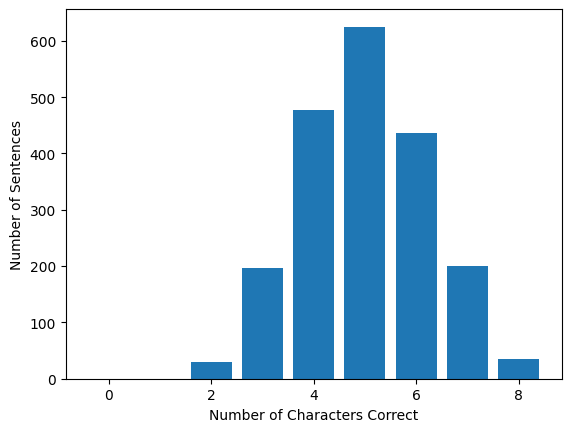

In [21]:
plot_dist(model, "Data/eval_data.csv")

# Plot Matrices

In [29]:
attn_weights = {}

def get_weights(name):
    def hook(model, input, output):
        attn_weights[name] = output[1].detach()
    return hook

model.transformer.decoder.decoders[-1].encoder_decoder_attention.register_forward_hook(get_weights('weights'))

In [40]:
model.predict("rycvotef")

'vynxrxdv'

In [41]:
attn_weights['weights'].shape

torch.Size([1, 4, 8, 8])

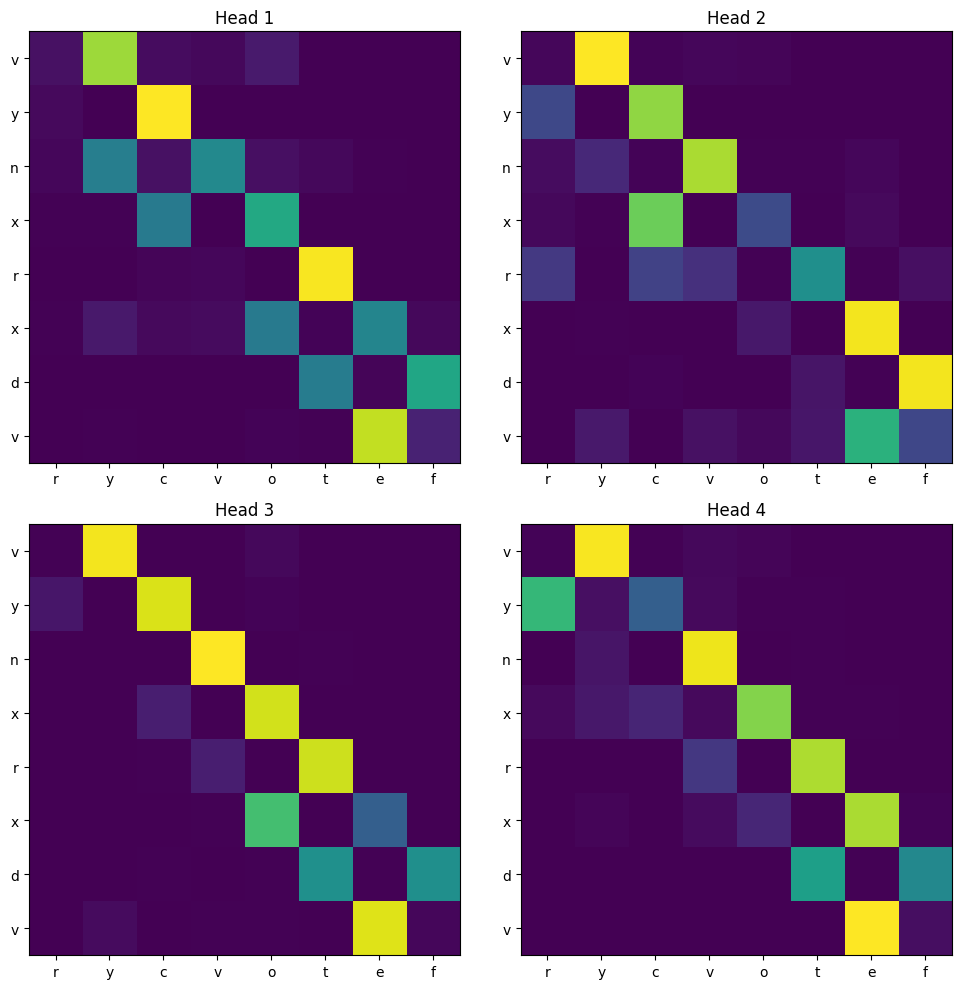

In [42]:
weights = attn_weights['weights'].cpu()

inputs = "rycvotef"
outputs = "vynxrxdv"

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(4):
    ax = axes[i//2, i%2]
    ax.imshow(weights[0, i], cmap='viridis', aspect='equal')
    ax.set_xticks(range(len(inputs)))
    ax.set_yticks(range(len(outputs)))
    ax.set_xticklabels(list(inputs))
    ax.set_yticklabels(list(outputs))
    ax.set_title(f'Head {i+1}')


plt.tight_layout()
plt.show()